## Description
This notebook tests a series of models on the MNIST number-recognition dataset - ultimately achieving >98% validation accuracy with an implementation of a ResNet CNN.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

## Read in Data

In [3]:
path = Path('./digit-recognizer')
tdat = pd.read_csv(path/'train.csv')
vdat = pd.read_csv(path/'test.csv')

In [4]:
tdat.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


So, each row is a 28x28 image stretched out across 784 columns. This can conveniently be pulled into a tensor. The corresponding labels will be the target tensor.

In [6]:
inputs = tdat.iloc[:, tdat.columns != 'label']
targets = tdat['label']

In [7]:
# let's look at one of the images
def view_digit(idx):
    df = pd.DataFrame(columns=[i for i in range(28)],
                      index=[i for i in range(28)])
    for i in range(28): df.loc[i] = inputs.iloc[idx, i*28:(i+1)*28].values.flatten().tolist()
    return df.apply(pd.to_numeric).style.background_gradient('Greys')

view_digit(idx=3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,220,179,6,0,0,0,0,0,0,0,0,9,77,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,28,247,17,0,0,0,0,0,0,0,0,27,202,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,242,155,0,0,0,0,0,0,0,0,27,254,63,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,160,207,6,0,0,0,0,0,0,0,27,254,65,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,127,254,21,0,0,0,0,0,0,0,20,239,65,0,0,0,0,0,0,0,0


Now we need to cast the data to tensors:

In [8]:
g = torch.Generator().manual_seed(42)

X = torch.tensor(inputs.values)
Y = torch.tensor(targets.values)

Xtr, Xval = torch.utils.data.random_split(X, [0.8, 0.2], generator=g)  # returns datasets
Ytr, Yval = torch.utils.data.random_split(X, [0.8, 0.2], generator=g)
len(Xtr), len(Xval)

(33600, 8400)

## Datasets & DataLoaders Tutorial

https://www.kaggle.com/code/pinocookie/pytorch-dataset-and-dataloader/notebook

### Custom DataSet Object

AFAIK, we have to construct a bespoke `DataSet` object in the style of the boilerplate PyTorch `DataSet` class. More on that here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files


In [9]:
from torch.utils.data import DataLoader, Dataset

In [823]:
class datMNIST(Dataset):
    def __init__(self, file_path, img_format=False):
        self.data = pd.read_csv(file_path)
        self.img_format = img_format
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        if self.img_format == True:
            # expand images into 28x28 format
            image = torch.tensor(self.data.iloc[index, 1:].values).view(1, 28, 28).float()
        else:
            image = torch.tensor(self.data.iloc[index, 1:].values).unsqueeze(0).float()
        
        image = image/255    # standardize inputs (255 is max pixel value)
        
        label = self.data.iloc[index, 0]
        
        return image, label

In [824]:
tdat = datMNIST(path/'train.csv', img_format=True)

In [115]:
img, lab = tdat.__getitem__(0)

In [62]:
type(img), type(lab)

(torch.Tensor, numpy.int64)

### Loading with a DataLoader

In [56]:
train_loader = DataLoader(tdat, batch_size=8, shuffle=True)

We can iterate over this with the `iter()` function:

In [57]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


In [58]:
images, labels = next(train_iter)

print('image batch:', images.shape)
print('labels batch:', labels.shape)

image batch: torch.Size([8, 1, 28, 28])
labels batch: torch.Size([8])


There's a super handy function to view the batched images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 242])


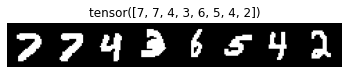

In [59]:
import torchvision.utils
grid = torchvision.utils.make_grid(images)  # expects (B,C,H,W)
print(grid.shape)
plt.imshow(grid.permute(1, 2, 0))    
plt.axis('off')
plt.title(labels);

Pretty cool.

In [224]:
tr_ds, val_ds = torch.utils.data.random_split(tdat, [0.8, 0.2]) 

In [226]:
len(tr_ds), len(val_ds)

(33600, 8400)

In [500]:
# increasing batch_size
tr_dl = DataLoader(tr_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(tr_ds, batch_size=128, shuffle=True)

In [505]:
# check new shapes
train_iter = iter(tr_dl)
val_iter = iter(val_dl)
xb, yb = next(train_iter)
xbv, ybv = next(val_iter)
print(f'training xb shape: {tuple(xb.shape)} | val xb shape: {tuple(xbv.shape)}')
print(f'training yb shape: {tuple(yb.shape)} | val yb shape: {tuple(ybv.shape)}')

training xb shape: (128, 1, 28, 28) | val xb shape: (128, 1, 28, 28)
training yb shape: (128,) | val yb shape: (128,)


## Basic MLP

In [186]:
class MLP(nn.Module):
    def __init__(self, n_layers, n_hidden):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.seq = nn.Sequential()
        
        for l in range(self.n_layers):
            fan_in = 784 if l == 0 else n_hidden
            self.seq.append(nn.Linear(fan_in, n_hidden))
            self.seq.append(nn.ReLU())
            
        self.seq.append(nn.Linear(n_hidden, 10))    # final output layer
                
    def forward(self, x):
#         seq = nn.Sequential(*self.layers)    # unpack list of modules into Sequential
        return self.seq(x)

In [282]:
model = MLP(n_layers=2, n_hidden=128)

for module in model.modules():
    name = module.__class__.__name__
    if name != "Sequential":
        print(module.__class__.__name__, sum(p.nelement() for p in module.parameters()))
        
for p in model.parameters(): p.requires_grad = True

MLP 118282
Linear 100480
ReLU 0
Linear 16512
ReLU 0
Linear 1290


#### Adam Test Class

In [97]:
class Adam:
    def __init__(self, params, lr):
        self.params = list(params)  # accepts model parameters at initialization
        self.lr = lr
        self.b1 = 0.9    # beta1
        self.b2 = 0.999  # beta2
        self.eps = 1e-8
        self.m = []       # first moment
        self.v = []       # second moment
        
        for p in self.params:    # init zero tensors of same shape as parameters tensors
            self.m.append(torch.zeros_like(p))
            self.v.append(torch.zeros_like(p))
            
    def step(self):
        idx = 0
        for p in self.params:
            self.m[idx] = self.b1*self.m[idx] + (1 - self.b1) * p.grad      # update first moment
            self.v[idx] = self.b2*self.v[idx] + (1 - self.b2) * p.grad**2   # update second moment
            m_hat = self.m[idx] #/(1 - self.b1**step)
            v_hat = self.v[idx] #/(1 - self.b2**step)
            p.data -= self.lr * m_hat / (v_hat + self.eps)
            idx += 1
            
    def zero_grad(self):
        for p in self.params: p.grad = None

In [112]:
optim = Adam(model.parameters(), lr = 0.01)

### Validation Loss Function

In [272]:
def val_metrics(model, val_data):
    accs = []
    losses = []
    for xb, yb in val_data:
        B, C, H, W = xb.shape
        xb = xb.view(B, C, -1)
        logits = model(xb)
        
        # calc loss
        batch_loss = F.cross_entropy(logits.squeeze(1), yb).item()
        
        # calc acc
        probs = F.softmax(logits, dim=2)
        preds = torch.argmax(probs, 2).squeeze(1)    # index values of max prob classes
        batch_acc = (preds == yb).float().mean().item()
        
        # standardize metrics for batch_size and append
        accs.append( batch_acc * (preds.nelement()/B) )
        losses.append( batch_loss * (preds.nelement()/B) )
    
    accuracy = sum(accs)/len(accs)
    loss = sum(losses)/len(losses)
    
#     accuracy = round(torch.stack(accs).mean().item(), 4)
#     loss = round(torch.stack(losses).mean().item(), 4)
    
    return round(accuracy, 4), round(loss, 4)

### Model Training

In [581]:
def train_mlp(model, tr_data, epochs):
    loss_tracker = []
    
    for epoch in range(epochs):
        loss_e = []
        for xb, yb in train_loader:
            B, C, H, W = xb.shape

            # forward
            logits = model(xb.view(B, C, -1))
            loss = F.cross_entropy(logits.squeeze(1), yb)    # we don't need C with only 1 channel
            loss_e.append(loss.item())
            
            # backward
            optim.zero_grad()
            loss.backward()

            # gradient descent
            optim.step()
        
        val_acc, val_loss = val_metrics(model, val_dl)
        
        loss_tracker.append(loss_e)
        print(f'Epoch: {epoch} | Avg Tr Loss: {sum(loss_e)/len(loss_e):.4f} \
              Val Loss: {val_loss} | Val Acc: {val_acc}')

In [284]:
optim = torch.optim.Adam(model.parameters())    # lr = 0.001 by default, inherent annealing

In [196]:
optim = torch.optim.SGD(model.parameters(), lr=0.001)

In [285]:
train(model, tr_dl, epochs=10)

Epoch: 0 | Avg Tr Loss: 0.4639 |               Val Loss: 0.149 | Val Acc: 0.953
Epoch: 1 | Avg Tr Loss: 0.1485 |               Val Loss: 0.1111 | Val Acc: 0.9663
Epoch: 2 | Avg Tr Loss: 0.1093 |               Val Loss: 0.0609 | Val Acc: 0.9807
Epoch: 3 | Avg Tr Loss: 0.0824 |               Val Loss: 0.0582 | Val Acc: 0.9807
Epoch: 4 | Avg Tr Loss: 0.0751 |               Val Loss: 0.0692 | Val Acc: 0.9772
Epoch: 5 | Avg Tr Loss: 0.0646 |               Val Loss: 0.0482 | Val Acc: 0.9838
Epoch: 6 | Avg Tr Loss: 0.0608 |               Val Loss: 0.045 | Val Acc: 0.9851
Epoch: 7 | Avg Tr Loss: 0.0648 |               Val Loss: 0.0557 | Val Acc: 0.9819
Epoch: 8 | Avg Tr Loss: 0.0589 |               Val Loss: 0.0581 | Val Acc: 0.9822
Epoch: 9 | Avg Tr Loss: 0.0395 |               Val Loss: 0.0525 | Val Acc: 0.984


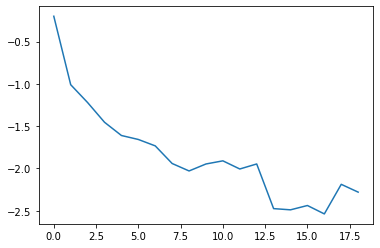

In [298]:
# import itertools
# loss_tracker = list(itertools.chain.from_iterable(loss_tracker))  # concat loss lists
plt.plot(torch.tensor(loss_tracker[:-37]).view(-1, 50).log().mean(1))

## Basic CNN

In [625]:
class CNN(nn.Module):
    def __init__(self, n_layers, n_chan, filter_size, padding=1, pooling=False):
        super().__init__()
        self.n_layers = n_layers
        self.n_chan = n_chan
        self.filter = filter_size
        self.seq = nn.Sequential()
        self.padding=padding
        self.pooling = pooling
        
        for l in range(n_layers):
            in_chan = 1 if l == 0 else n_chan
            self.seq.append(nn.Conv2d(in_channels = in_chan, 
                                      out_channels = self.n_chan,
                                      kernel_size = self.filter,
                                      padding = self.padding))
            self.seq.append(nn.ReLU())
        
        self.flatten = nn.Flatten()
        
        # choose kernel_size < filter_size and s.t. 28 % kernel_size = 0 (so filters do not overlap)
        if self.pooling == "Max":
            self.seq.append(nn.MaxPool2d(kernel_size=2))
        elif self.pooling == "Mean":
            self.seq.append(nn.AvgPool2d(kernel_size=2))
        
        if self.pooling == False:
            self.linear_output = nn.Linear(n_chan*784, 10)
        else:
            self.linear_output = nn.Linear(n_chan*14*14, 10)
        
    def forward(self, x):
        B, C, H, W = x.shape                             # get dimensions
        out = self.seq(x)                                # pass through conv layers
        out = out.view(B, self.n_chan, -1)               # reshape for linear layer
        out = self.flatten(out)                          # flatten
        out = self.linear_output(out)                    # output
        return out

In [477]:
model = CNN(n_layers = 2,
            n_chan = 1,
            filter_size = 3,
            padding = 1,
            pooling = "Max")
for module in model.modules():
    name = module.__class__.__name__
    if name != "Sequential":
        print(module.__class__.__name__, sum(p.nelement() for p in module.parameters()))
        
for p in model.parameters(): p.requires_grad = True

CNN 1990
Conv2d 10
ReLU 0
Conv2d 10
ReLU 0
MaxPool2d 0
Linear 1970


### Validation Metrics

In [449]:
def val_metrics_cnn(model, val_data):
    accs = []
    losses = []
    for xb, yb in val_data:
        logits = model(xb)
        
        # calc loss
        batch_loss = F.cross_entropy(logits.squeeze(1), yb).item()
        
        # calc acc
        probs = F.softmax(logits, dim=2)
        preds = torch.argmax(probs, 2).squeeze(1)    # index values of max prob classes
        batch_acc = (preds == yb).float().mean().item()
        
        # standardize metrics for batch_size and append
        accs.append( batch_acc * (preds.nelement()/B) )
        losses.append( batch_loss * (preds.nelement()/B) )
    
    accuracy = sum(accs)/len(accs)
    loss = sum(losses)/len(losses)
    
#     accuracy = round(torch.stack(accs).mean().item(), 4)
#     loss = round(torch.stack(losses).mean().item(), 4)
    
    return round(accuracy, 4), round(loss, 4)

### Model Training

In [629]:
def train_cnn(model, tr_data, epochs):
    for epoch in range(epochs):
        loss_e = []
        for xb, yb in tr_data:
            
            # forward
            loss = F.cross_entropy(model(xb).squeeze(1), yb)
            
            # backward
            optim.zero_grad()
            loss.backward()
            
            # gradient descent
            optim.step()
            
            loss_e.append(loss)
        
        val_acc, val_loss = val_metrics_cnn(model, val_dl)
        
        print(f'Epoch: {epoch} | Avg Training Loss: {torch.stack(loss_e).mean().item():.4f} \
              Val Loss: {val_loss} | Val Acc: {val_acc}')

#### SGD (k=3, pooling=False)

In [440]:
optim = torch.optim.SGD(model.parameters(), lr = 0.01)

In [438]:
train_cnn(model, tr_dl, epochs=10)   # n_layers = 2

Epoch: 0 | Avg Training Loss: 0.5876 
Epoch: 1 | Avg Training Loss: 0.3202 
Epoch: 2 | Avg Training Loss: 0.2896 
Epoch: 3 | Avg Training Loss: 0.2697 
Epoch: 4 | Avg Training Loss: 0.2567 
Epoch: 5 | Avg Training Loss: 0.2460 
Epoch: 6 | Avg Training Loss: 0.2383 
Epoch: 7 | Avg Training Loss: 0.2334 
Epoch: 8 | Avg Training Loss: 0.2306 
Epoch: 9 | Avg Training Loss: 0.2265 


In [441]:
train_cnn(model, tr_dl, epochs=10)   # n_layers = 4

Epoch: 0 | Avg Training Loss: 0.6013 
Epoch: 1 | Avg Training Loss: 0.3204 
Epoch: 2 | Avg Training Loss: 0.2899 
Epoch: 3 | Avg Training Loss: 0.2739 
Epoch: 4 | Avg Training Loss: 0.2622 
Epoch: 5 | Avg Training Loss: 0.2522 
Epoch: 6 | Avg Training Loss: 0.2442 
Epoch: 7 | Avg Training Loss: 0.2372 
Epoch: 8 | Avg Training Loss: 0.2300 
Epoch: 9 | Avg Training Loss: 0.2254 


#### Adam (k=3, pooling=False)

In [447]:
optim = torch.optim.Adam(model.parameters())

In [445]:
train_cnn(model, tr_dl, epochs=10)   # n_layers = 2, Adam

Epoch: 0 | Avg Training Loss: 0.5729 
Epoch: 1 | Avg Training Loss: 0.3669 
Epoch: 2 | Avg Training Loss: 0.3353 
Epoch: 3 | Avg Training Loss: 0.3010 
Epoch: 4 | Avg Training Loss: 0.2704 
Epoch: 5 | Avg Training Loss: 0.2534 
Epoch: 6 | Avg Training Loss: 0.2400 
Epoch: 7 | Avg Training Loss: 0.2293 
Epoch: 8 | Avg Training Loss: 0.2205 
Epoch: 9 | Avg Training Loss: 0.2136 


In [448]:
train_cnn(model, tr_dl, epochs=10)   # n_layers = 4, Adam

Epoch: 0 | Avg Training Loss: 1.0108 
Epoch: 1 | Avg Training Loss: 0.3038 
Epoch: 2 | Avg Training Loss: 0.2705 
Epoch: 3 | Avg Training Loss: 0.2549 
Epoch: 4 | Avg Training Loss: 0.2448 
Epoch: 5 | Avg Training Loss: 0.2393 
Epoch: 6 | Avg Training Loss: 0.2320 
Epoch: 7 | Avg Training Loss: 0.2314 
Epoch: 8 | Avg Training Loss: 0.2255 
Epoch: 9 | Avg Training Loss: 0.2233 


In [451]:
val_metrics_cnn(model, val_dl)

(0.9323, 0.2118)

#### Adam (pooling="Max")

In [484]:
model = CNN(n_layers = 4,
            n_chan = 1,
            filter_size = 5,
            padding = 2,
            pooling = "Max")

In [485]:
optim = torch.optim.Adam(model.parameters())

In [480]:
train_cnn(model, tr_dl, epochs=10)   # n_layers = 2, k = 3, Adam

Epoch: 0 | Avg Training Loss: 3.0042 
Epoch: 1 | Avg Training Loss: 0.4825 
Epoch: 2 | Avg Training Loss: 0.3562 
Epoch: 3 | Avg Training Loss: 0.3081 
Epoch: 4 | Avg Training Loss: 0.2798 
Epoch: 5 | Avg Training Loss: 0.2610 
Epoch: 6 | Avg Training Loss: 0.2493 
Epoch: 7 | Avg Training Loss: 0.2397 
Epoch: 8 | Avg Training Loss: 0.2326 
Epoch: 9 | Avg Training Loss: 0.2278 


In [483]:
train_cnn(model, tr_dl, epochs=10)   # n_layers = 2, k = 5, Adam

Epoch: 0 | Avg Training Loss: 0.8224 
Epoch: 1 | Avg Training Loss: 0.2485 
Epoch: 2 | Avg Training Loss: 0.2034 
Epoch: 3 | Avg Training Loss: 0.1840 
Epoch: 4 | Avg Training Loss: 0.1765 
Epoch: 5 | Avg Training Loss: 0.1693 
Epoch: 6 | Avg Training Loss: 0.1632 
Epoch: 7 | Avg Training Loss: 0.1600 
Epoch: 8 | Avg Training Loss: 0.1560 
Epoch: 9 | Avg Training Loss: 0.1539 


In [486]:
train_cnn(model, tr_dl, epochs=10)   # n_layers = 4, k = 5, Adam

Epoch: 0 | Avg Training Loss: 0.6856 
Epoch: 1 | Avg Training Loss: 0.3359 
Epoch: 2 | Avg Training Loss: 0.2918 
Epoch: 3 | Avg Training Loss: 0.2643 
Epoch: 4 | Avg Training Loss: 0.2450 
Epoch: 5 | Avg Training Loss: 0.2331 
Epoch: 6 | Avg Training Loss: 0.2181 
Epoch: 7 | Avg Training Loss: 0.2112 
Epoch: 8 | Avg Training Loss: 0.2021 
Epoch: 9 | Avg Training Loss: 0.1964 


#### Adam (pooling="Mean")

In [508]:
model = CNN(n_layers = 2,
            n_chan = 1,
            filter_size = 5,
            padding = 2,
            pooling = "Mean")

In [509]:
optim = torch.optim.Adam(model.parameters())

In [510]:
train_cnn(model, tr_dl, epochs=10)   # n_layers = 2, k = 5, Adam

Epoch: 0 | Avg Training Loss: 0.7935 
Epoch: 1 | Avg Training Loss: 0.3193 
Epoch: 2 | Avg Training Loss: 0.2659 
Epoch: 3 | Avg Training Loss: 0.2373 
Epoch: 4 | Avg Training Loss: 0.2204 
Epoch: 5 | Avg Training Loss: 0.2077 
Epoch: 6 | Avg Training Loss: 0.1965 
Epoch: 7 | Avg Training Loss: 0.1916 
Epoch: 8 | Avg Training Loss: 0.1867 
Epoch: 9 | Avg Training Loss: 0.1806 


In [511]:
val_metrics_cnn(model, val_dl)

(0.9445, 0.173)

In [503]:
train_cnn(model, tr_dl, epochs=10)   # n_layers = 4, k = 5, Adam

Epoch: 0 | Avg Training Loss: 0.6827 
Epoch: 1 | Avg Training Loss: 0.3019 
Epoch: 2 | Avg Training Loss: 0.2609 
Epoch: 3 | Avg Training Loss: 0.2390 
Epoch: 4 | Avg Training Loss: 0.2254 
Epoch: 5 | Avg Training Loss: 0.2142 
Epoch: 6 | Avg Training Loss: 0.2036 
Epoch: 7 | Avg Training Loss: 0.1962 
Epoch: 8 | Avg Training Loss: 0.1894 
Epoch: 9 | Avg Training Loss: 0.1853 


In [504]:
val_metrics_cnn(model, val_dl)

(0.9472, 0.1679)

### Manual Replication of Convolution

To better understand the nn.Conv2d module, I replicate the convolved output with a 'chunkated' dot-product loop.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


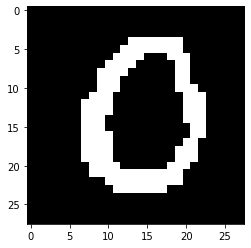

In [305]:
x = xb[0].view(1, 28, 28)
grid = torchvision.utils.make_grid(x)  # expects (B,C,H,W)
plt.imshow(grid.permute(1, 2, 0));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 28, 28])


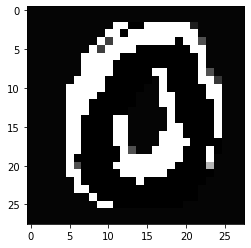

In [464]:
c = nn.Conv2d(1, 1, 5, padding=2)   # applies padding to both sides
conv_x = c(x)
print(conv_x.shape)    # input_size - (k - 1)*d
grid = torchvision.utils.make_grid(conv_x)
plt.imshow(grid.permute(1, 2, 0));

Dimensions are reduced by (k - 1)*d. Because padding is added to all sides of the image, padding increases the input dimensions by 2. So, for an input of [28, 28] and (k=3, d=1, padding=1):
    
    Output dimensions: [28+2 - (3-1)*1, 28+2 - (3-1)*1] = [28, 28]

Scaling up, in order to maintain the input dimensions, the padding must satisfy:

    padding = (k - 1)*d / 2
    
It follows that the filter size (k) must also satisfy this equality in order for padding to work (be integer-valued).

In [475]:
pool = nn.MaxPool2d(2)
pool(conv_x).shape

torch.Size([1, 14, 14])

In [390]:
# parameters from the nn.Conv2d layer
k = c.weight    # weights
b = c.bias      # bias
k, b

(Parameter containing:
 tensor([[[[-0.1623, -0.0603,  0.0339],
           [-0.1806, -0.0308,  0.0628],
           [ 0.3279,  0.2601, -0.2356]]]], requires_grad=True),
 Parameter containing:
 tensor([-0.2511], requires_grad=True))

In [391]:
# convolved sample
conv_x[0, 6:9, 12:15]

tensor([[ 90.2767,  36.9687, -60.5300],
        [ 49.3970, -37.9311, -76.2787],
        [-21.0253, -83.8580, -21.0247]], grad_fn=<SliceBackward0>)

In [406]:
# corresponding sample from input image
sx = x[0,6:9, 12:15]
sx

tensor([[255., 255., 191.],
        [255., 128.,   0.],
        [191.,   0.,   0.]])

In [407]:
# convolved output
(sx * k).sum() + b    # dot-product plus bias

tensor([-37.9311], grad_fn=<AddBackward0>)

In [402]:
# pad x because the conv layer includes padding
x_pad = F.pad(x, (1,1,1,1)).squeeze(0)    # padding is added to all sides of the input
x_pad.shape

torch.Size([30, 30])

In [403]:
# loop over padded x, applying convolution
out = torch.zeros(28, 28)
for row in range(x_pad.shape[0] - 3):
    for col in range(x_pad.shape[1] - 3):
        out[row,col] = (x_pad[row:(row+3), col:(col+3)] * k).sum() + b

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


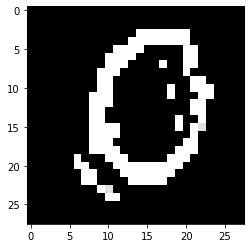

In [405]:
# print resulting convolved image
grid = torchvision.utils.make_grid(out.unsqueeze(0))
plt.imshow(grid.permute(1, 2, 0));

## ResNet

Residual blocks follow structure presented in: "Deep Learning for Image Recognition" https://arxiv.org/abs/1512.03385

In [567]:
class ResNet(nn.Module):
    def __init__(self, n_blocks, filter_size, padding=1, pooling=False):
        super().__init__()
        self.n_blocks = n_blocks
        self.filter = filter_size
        self.padding = padding
        self.pooling = pooling
        self.blocks = nn.Sequential()
        
        self.in_conv = nn.Conv2d(in_channels = 1,
                                 out_channels = 1,
                                 kernel_size = self.filter,
                                 padding = self.padding)
        
        for b in range(self.n_blocks):
            # residual block
            self.blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_channels = 1, 
                              out_channels = 1, 
                              kernel_size = self.filter,
                              padding = self.padding)
                    ,nn.BatchNorm2d(1)
                    ,nn.ReLU()
                    ,nn.Conv2d(in_channels = 1, 
                              out_channels = 1, 
                              kernel_size = self.filter,
                              padding = self.padding)
                    ,nn.BatchNorm2d(1)
                )
            )

        # choose kernel_size < filter_size and s.t. 28 % kernel_size = 0 (so filters do not overlap)
        if self.pooling == "Max":
            self.pool = nn.MaxPool2d(kernel_size=2)
            self.linear_output = nn.Linear(14*14, 10)    # final output layer
        elif self.pooling == "Mean":
            self.pool = nn.AvgPool2d(kernel_size=2)
            self.linear_output = nn.Linear(14*14, 10)    # final output layer
        else:
            self.linear_output = nn.Linear(28*28, 10)    # final output layer
            
    def forward(self, x):
        B, C, H, W = x.shape
        x = self.in_conv(x)                              # pass through initial conv layer
        for b in self.blocks: x = F.relu(b(x) + x)       # pass through residual blocks
        if self.pooling != False: x = self.pool(x)       # pool before output
        x = x.view(B, C, -1)                             # reshape for linear output layer
        logits = self.linear_output(x)                   # output
        
        return logits        

In [589]:
model = ResNet(n_blocks = 3,
               filter_size = 3,
               padding = 1,
               pooling = False)

for p in model.parameters(): p.requires_grad = True

for module in model.modules():
    name = module.__class__.__name__
    if name != "Sequential":
        print(module.__class__.__name__, sum(p.nelement() for p in module.parameters()))

ResNet 7932
Conv2d 10
BatchNorm2d 2
ReLU 0
Conv2d 10
BatchNorm2d 2
Conv2d 10
BatchNorm2d 2
ReLU 0
Conv2d 10
BatchNorm2d 2
Conv2d 10
BatchNorm2d 2
ReLU 0
Conv2d 10
BatchNorm2d 2
Conv2d 10
Linear 7850


### Model Training

In [590]:
optim = torch.optim.Adam(model.parameters())

In [661]:
def train_resnet(model, tr_data, epochs):
    model.train()
    for epoch in range(epochs):
        loss_e = []
        for xb, yb in tr_data:
            
            # forward
            loss = F.cross_entropy(model(xb).squeeze(1), yb)
            
            # backward
            optim.zero_grad()
            loss.backward()
            
            # gradient descent
            optim.step()
            
            loss_e.append(loss)
        
        val_acc, val_loss = val_metrics_cnn(model, val_dl)
        
        print(f'Epoch: {epoch} | Avg Training Loss: {torch.stack(loss_e).mean().item():.4f} \
              Val Loss: {val_loss} | Val Acc: {val_acc}')

In [549]:
train_resnet(model, tr_dl, epochs=10)    # n_blocks = 2

Epoch: 0 | Avg Training Loss: 1.3135 
Epoch: 1 | Avg Training Loss: 0.4031 
Epoch: 2 | Avg Training Loss: 0.3225 
Epoch: 3 | Avg Training Loss: 0.2827 
Epoch: 4 | Avg Training Loss: 0.2570 
Epoch: 5 | Avg Training Loss: 0.2258 
Epoch: 6 | Avg Training Loss: 0.2070 
Epoch: 7 | Avg Training Loss: 0.1921 
Epoch: 8 | Avg Training Loss: 0.1841 
Epoch: 9 | Avg Training Loss: 0.1716 


In [552]:
train_resnet(model, tr_dl, epochs=10)    # n_blocks = 3

Epoch: 0 | Avg Training Loss: 0.9457 
Epoch: 1 | Avg Training Loss: 0.3805 
Epoch: 2 | Avg Training Loss: 0.2927 
Epoch: 3 | Avg Training Loss: 0.2377 
Epoch: 4 | Avg Training Loss: 0.2091 
Epoch: 5 | Avg Training Loss: 0.1860 
Epoch: 6 | Avg Training Loss: 0.1739 
Epoch: 7 | Avg Training Loss: 0.1641 
Epoch: 8 | Avg Training Loss: 0.1572 
Epoch: 9 | Avg Training Loss: 0.1486 


In [573]:
train_resnet(model, tr_dl, epochs=10)    # n_blocks = 4

Epoch: 0 | Avg Training Loss: 1.4184 
Epoch: 1 | Avg Training Loss: 0.4174 
Epoch: 2 | Avg Training Loss: 0.3147 
Epoch: 3 | Avg Training Loss: 0.2588 
Epoch: 4 | Avg Training Loss: 0.2295 
Epoch: 5 | Avg Training Loss: 0.2071 
Epoch: 6 | Avg Training Loss: 0.1891 
Epoch: 7 | Avg Training Loss: 0.1788 
Epoch: 8 | Avg Training Loss: 0.1683 
Epoch: 9 | Avg Training Loss: 0.1583 


In [563]:
train_resnet(model, tr_dl, epochs=10)   # 3 blocks and average pooling

Epoch: 0 | Avg Training Loss: 1.3885 
Epoch: 1 | Avg Training Loss: 0.4328 
Epoch: 2 | Avg Training Loss: 0.3369 
Epoch: 3 | Avg Training Loss: 0.2737 
Epoch: 4 | Avg Training Loss: 0.2360 
Epoch: 5 | Avg Training Loss: 0.2120 
Epoch: 6 | Avg Training Loss: 0.1958 
Epoch: 7 | Avg Training Loss: 0.1838 
Epoch: 8 | Avg Training Loss: 0.1743 
Epoch: 9 | Avg Training Loss: 0.1684 


In [576]:
train_resnet(model, tr_dl, epochs=10)   # 3 blocks and max pooling

Epoch: 0 | Avg Training Loss: 3.0095 
Epoch: 1 | Avg Training Loss: 0.5219 
Epoch: 2 | Avg Training Loss: 0.3656 
Epoch: 3 | Avg Training Loss: 0.3173 
Epoch: 4 | Avg Training Loss: 0.2947 
Epoch: 5 | Avg Training Loss: 0.2825 
Epoch: 6 | Avg Training Loss: 0.2727 
Epoch: 7 | Avg Training Loss: 0.2669 
Epoch: 8 | Avg Training Loss: 0.2675 
Epoch: 9 | Avg Training Loss: 0.2570 


Unexpectedly, 3 blocks seems to do best - at least with only 10 epochs. A deeper net may converge to a lower loss (?) just more slowly. Let's try training the 3 block model for longer and validate it. These differences in loss achieved are rather small and may be due to differences in initializations. Scaling up to 6 blocks lead to significantly worse loss values, especially at initialization. So, it may be the case that the deeper models are more sensitive to initial conditions. As for pooling, it seems that pooling isn't beneficial.

In [592]:
train_resnet(model, tr_dl, epochs=20)    # n_blocks = 3

Epoch: 0 | Avg Training Loss: 1.4979               Val Loss: 0.454 | Val Error: 0.8771
Epoch: 1 | Avg Training Loss: 0.4220               Val Loss: 0.324 | Val Error: 0.8988
Epoch: 2 | Avg Training Loss: 0.3324               Val Loss: 0.2809 | Val Error: 0.91
Epoch: 3 | Avg Training Loss: 0.2946               Val Loss: 0.2638 | Val Error: 0.9155
Epoch: 4 | Avg Training Loss: 0.2728               Val Loss: 0.2468 | Val Error: 0.9189
Epoch: 5 | Avg Training Loss: 0.2534               Val Loss: 0.2149 | Val Error: 0.9311
Epoch: 6 | Avg Training Loss: 0.2367               Val Loss: 0.2151 | Val Error: 0.9302
Epoch: 7 | Avg Training Loss: 0.2283               Val Loss: 0.2119 | Val Error: 0.929
Epoch: 8 | Avg Training Loss: 0.2162               Val Loss: 0.185 | Val Error: 0.9398
Epoch: 9 | Avg Training Loss: 0.2057               Val Loss: 0.1749 | Val Error: 0.942
Epoch: 10 | Avg Training Loss: 0.1972               Val Loss: 0.1718 | Val Error: 0.9428
Epoch: 11 | Avg Training Loss: 0.1889 

So, why has the generic linear MLP continued to outperform even after this resnet has been trained for 20 epochs...? Let's see how far the MLP can go in 20 epochs...

In [583]:
model = MLP(n_layers=2, n_hidden=128)
optim = torch.optim.Adam(model.parameters())

In [584]:
train_mlp(model, tr_dl, epochs=20)

Epoch: 0 | Avg Tr Loss: 0.4226               Val Loss: 0.1952 | Val Acc: 0.9433
Epoch: 1 | Avg Tr Loss: 0.1488               Val Loss: 0.1214 | Val Acc: 0.9617
Epoch: 2 | Avg Tr Loss: 0.1152               Val Loss: 0.1302 | Val Acc: 0.959
Epoch: 3 | Avg Tr Loss: 0.0976               Val Loss: 0.0616 | Val Acc: 0.9799
Epoch: 4 | Avg Tr Loss: 0.0860               Val Loss: 0.0724 | Val Acc: 0.976
Epoch: 5 | Avg Tr Loss: 0.0660               Val Loss: 0.0488 | Val Acc: 0.9848
Epoch: 6 | Avg Tr Loss: 0.0672               Val Loss: 0.0436 | Val Acc: 0.986
Epoch: 7 | Avg Tr Loss: 0.0550               Val Loss: 0.0355 | Val Acc: 0.9881
Epoch: 8 | Avg Tr Loss: 0.0501               Val Loss: 0.0488 | Val Acc: 0.9851
Epoch: 9 | Avg Tr Loss: 0.0614               Val Loss: 0.0487 | Val Acc: 0.9843
Epoch: 10 | Avg Tr Loss: 0.0522               Val Loss: 0.0494 | Val Acc: 0.9857
Epoch: 11 | Avg Tr Loss: 0.0537               Val Loss: 0.0404 | Val Acc: 0.988
Epoch: 12 | Avg Tr Loss: 0.0493           

Interesting. The resnet underperformed the MLP by 20 epochs but was continuing to sho improvements in validation accuracy while the MLP had stopped improving by that point. Let's try training the resnet for another 10 epochs on top of the 20 it has already trained for:

In [593]:
train_resnet(model, tr_dl, epochs=10)    # n_blocks = 3

Epoch: 0 | Avg Training Loss: 0.1236               Val Loss: 0.1063 | Val Error: 0.9627
Epoch: 1 | Avg Training Loss: 0.1196               Val Loss: 0.103 | Val Error: 0.9651
Epoch: 2 | Avg Training Loss: 0.1160               Val Loss: 0.1015 | Val Error: 0.9645
Epoch: 3 | Avg Training Loss: 0.1109               Val Loss: 0.086 | Val Error: 0.9707
Epoch: 4 | Avg Training Loss: 0.1057               Val Loss: 0.0895 | Val Error: 0.9695
Epoch: 5 | Avg Training Loss: 0.1060               Val Loss: 0.0824 | Val Error: 0.9718
Epoch: 6 | Avg Training Loss: 0.1020               Val Loss: 0.1077 | Val Error: 0.9617
Epoch: 7 | Avg Training Loss: 0.0992               Val Loss: 0.0818 | Val Error: 0.9708
Epoch: 8 | Avg Training Loss: 0.0996               Val Loss: 0.0881 | Val Error: 0.9688
Epoch: 9 | Avg Training Loss: 0.0972               Val Loss: 0.0739 | Val Error: 0.9731


## Thoughts

So, it looks like the resnet was near its limit at 20 epochs :(

The best validation accuracy that we have been able to achieve was 99.43% at epoch 17 with the 2-layer MLP. CNNs, at least as complex (i.e. as simple) as these, don't seem to offer improvements upon the brute-force approach of an MLP. Getting that last 0.57% accuracy may require something really novel...

We could possibly get some "easy" gains by augmenting the dataset with image augmentation. But still... this notebook (https://www.kaggle.com/code/cdeotte/25-million-images-0-99757-mnist) trained an ensemble of 15 CNNs on 25 million augmented MNIST images and only achieved 99.757% accuracy. It suggests that the leaderboard positions with 100% accuracy trained on the full MNIST dataset (so on the test set which included labels) and that no published notebooks achieve a higher accuracy than this one. They provide this histogram:
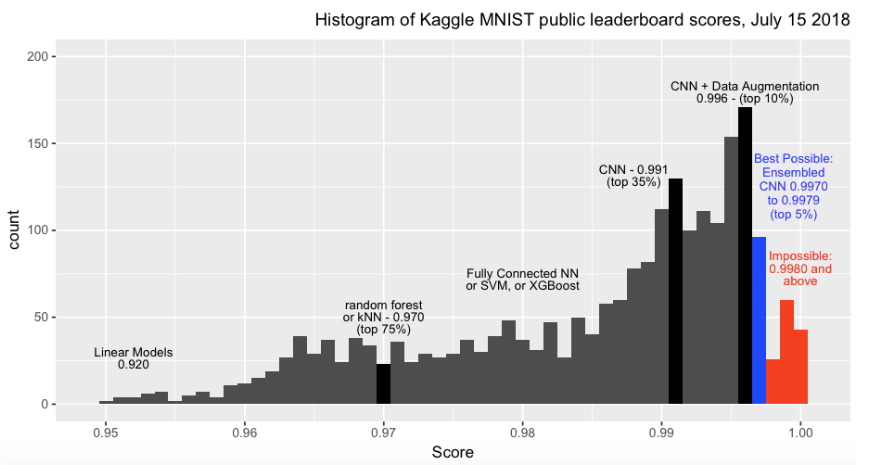

So, I suppose I ought to doubt that the 99.43% validation accuracy achieved by the simple 2-layer MLP would hold up on the test set. But even if it gives up a bit of accuracy, it's still incredible how much more work is required to add just a few tenths of a percentage point of accuracy...

Still, this casts further suspicion on the resnet! Random forests and kNN approaches achieved accuracy in the 97%-percentile, it's truly surprising that the resnet would do worse than that. There must be room to tinker around here. Let's try to peal apart the model and see what's happening during training.


## Re-Training CNN with More Filters (Output Channels)

### Re-Factor Validation Function

In [660]:
def val_metrics_cnn(model, val_data):
    
    model.eval()
    
    accs = []
    losses = []
    for xb, yb in val_data:
        logits = model(xb)
        
        # calc loss
        batch_loss = F.cross_entropy(logits.squeeze(1), yb).item()
        
        # calc acc
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, 1)    # index values of max prob classes
        batch_acc = (preds == yb).float().mean().item()
        
        # standardize metrics for batch_size and append
        accs.append( batch_acc * (preds.nelement()/B) )
        losses.append( batch_loss * (preds.nelement()/B) )
    
    accuracy = sum(accs)/len(accs)
    loss = sum(losses)/len(losses)
    
    model.train()
    
#     accuracy = round(torch.stack(accs).mean().item(), 4)
#     loss = round(torch.stack(losses).mean().item(), 4)
    
    return round(accuracy, 4), round(loss, 4)

### Train Model

In [641]:
model = CNN(n_layers = 2,
            n_chan = 3,
            filter_size = 3,
            padding = 1,
            pooling = False)

In [642]:
optim = torch.optim.Adam(model.parameters())
train_cnn(model, tr_dl, epochs=10)

Epoch: 0 | Avg Training Loss: 0.3141               Val Loss: 0.106 | Val Acc: 0.9651
Epoch: 1 | Avg Training Loss: 0.1146               Val Loss: 0.0648 | Val Acc: 0.9795
Epoch: 2 | Avg Training Loss: 0.0796               Val Loss: 0.05 | Val Acc: 0.9814
Epoch: 3 | Avg Training Loss: 0.0611               Val Loss: 0.034 | Val Acc: 0.9873
Epoch: 4 | Avg Training Loss: 0.0472               Val Loss: 0.0337 | Val Acc: 0.9875
Epoch: 5 | Avg Training Loss: 0.0392               Val Loss: 0.0237 | Val Acc: 0.9903
Epoch: 6 | Avg Training Loss: 0.0309               Val Loss: 0.017 | Val Acc: 0.9924
Epoch: 7 | Avg Training Loss: 0.0304               Val Loss: 0.0246 | Val Acc: 0.9896
Epoch: 8 | Avg Training Loss: 0.0273               Val Loss: 0.0259 | Val Acc: 0.9891
Epoch: 9 | Avg Training Loss: 0.0233               Val Loss: 0.0136 | Val Acc: 0.9937


Game changer - absolutely fucking essential quality of CNNs that I just completely overlooked. Each filter can learn something different about the image. Of course, the value of new things learnt diminishes as the number of filters increases. This is totally crucial. Let's try adding more filters:

In [643]:
model = CNN(n_layers = 2,
            n_chan = 32,       # first conv layers in the resnet paper had 32 filters
            filter_size = 3,
            padding = 1,
            pooling = False)

optim = torch.optim.Adam(model.parameters())
train_cnn(model, tr_dl, epochs=10)

Epoch: 0 | Avg Training Loss: 1.0538               Val Loss: 0.0707 | Val Acc: 0.9751
Epoch: 1 | Avg Training Loss: 0.0681               Val Loss: 0.0352 | Val Acc: 0.9868
Epoch: 2 | Avg Training Loss: 0.0464               Val Loss: 0.0279 | Val Acc: 0.9887
Epoch: 3 | Avg Training Loss: 0.0415               Val Loss: 0.0329 | Val Acc: 0.9872
Epoch: 4 | Avg Training Loss: 0.0353               Val Loss: 0.0211 | Val Acc: 0.9911
Epoch: 5 | Avg Training Loss: 0.0275               Val Loss: 0.0196 | Val Acc: 0.992
Epoch: 6 | Avg Training Loss: 0.0160               Val Loss: 0.0097 | Val Acc: 0.9947
Epoch: 7 | Avg Training Loss: 0.0250               Val Loss: 0.0263 | Val Acc: 0.9903
Epoch: 8 | Avg Training Loss: 0.0317               Val Loss: 0.0122 | Val Acc: 0.9936
Epoch: 9 | Avg Training Loss: 0.0306               Val Loss: 0.024 | Val Acc: 0.992


In [646]:
model = CNN(n_layers = 4,
            n_chan = 3,
            filter_size = 3,
            padding = 1,
            pooling = False)

optim = torch.optim.Adam(model.parameters())
train_cnn(model, tr_dl, epochs=10)

Epoch: 0 | Avg Training Loss: 0.2992               Val Loss: 0.1127 | Val Acc: 0.9643
Epoch: 1 | Avg Training Loss: 0.1054               Val Loss: 0.0834 | Val Acc: 0.9706
Epoch: 2 | Avg Training Loss: 0.0780               Val Loss: 0.0579 | Val Acc: 0.9798
Epoch: 3 | Avg Training Loss: 0.0601               Val Loss: 0.0402 | Val Acc: 0.9851
Epoch: 4 | Avg Training Loss: 0.0513               Val Loss: 0.0416 | Val Acc: 0.9849
Epoch: 5 | Avg Training Loss: 0.0392               Val Loss: 0.0261 | Val Acc: 0.9901
Epoch: 6 | Avg Training Loss: 0.0333               Val Loss: 0.0228 | Val Acc: 0.9913
Epoch: 7 | Avg Training Loss: 0.0292               Val Loss: 0.0347 | Val Acc: 0.9869
Epoch: 8 | Avg Training Loss: 0.0250               Val Loss: 0.0169 | Val Acc: 0.9923
Epoch: 9 | Avg Training Loss: 0.0210               Val Loss: 0.0145 | Val Acc: 0.9935


## ResNet with Multiple Filters

### Modify Class

In [657]:
class ResNet(nn.Module):
    def __init__(self, n_blocks, n_chan, filter_size, padding=1, pooling=False):
        super().__init__()
        self.n_blocks = n_blocks
        self.n_chan = n_chan
        self.filter = filter_size
        self.padding = padding
        self.pooling = pooling
        self.blocks = nn.Sequential()
        
        self.in_conv = nn.Conv2d(in_channels = 1,
                                 out_channels = self.n_chan,
                                 kernel_size = self.filter,
                                 padding = self.padding)
        
        for b in range(self.n_blocks):
            # residual block
            self.blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_channels = self.n_chan, 
                              out_channels = self.n_chan, 
                              kernel_size = self.filter,
                              padding = self.padding)
                    ,nn.BatchNorm2d(self.n_chan)
                    ,nn.ReLU()
                    ,nn.Conv2d(in_channels = self.n_chan, 
                              out_channels = self.n_chan, 
                              kernel_size = self.filter,
                              padding = self.padding)
                    ,nn.BatchNorm2d(self.n_chan)
                )
            )

        self.flatten = nn.Flatten()
            
        # choose kernel_size < filter_size and s.t. 28 % kernel_size = 0 (so filters do not overlap)
        if self.pooling == "Max":
            self.pool = nn.MaxPool2d(kernel_size=2)
            self.linear_output = nn.Linear(self.n_chan*14*14, 10)    # final output layer
        elif self.pooling == "Mean":
            self.pool = nn.AvgPool2d(kernel_size=2)
            self.linear_output = nn.Linear(self.n_chan*14*14, 10)    # final output layer
        else:
            self.linear_output = nn.Linear(self.n_chan*28*28, 10)    # final output layer
            
    def forward(self, x):
        B, C, H, W = x.shape
        x = self.in_conv(x)                              # pass through initial conv layer
        for b in self.blocks: x = F.relu(b(x) + x)       # pass through residual blocks
        if self.pooling != False: x = self.pool(x)       # pool before output
        x = x.view(B, self.n_chan, -1)                   # reshape for linear output layer
        x = self.flatten(x)
        logits = self.linear_output(x)                   # output
        
        return logits 

### Re-Train

In [662]:
model = ResNet(n_blocks = 3,
               n_chan = 3,
               filter_size = 3,
               padding = 1,
               pooling = False)
optim = torch.optim.Adam(model.parameters())
train_resnet(model, tr_dl, epochs=10)

Epoch: 0 | Avg Training Loss: 2.0112               Val Loss: 0.3459 | Val Acc: 0.9433
Epoch: 1 | Avg Training Loss: 0.3320               Val Loss: 0.1981 | Val Acc: 0.9509
Epoch: 2 | Avg Training Loss: 0.1716               Val Loss: 0.1281 | Val Acc: 0.9602
Epoch: 3 | Avg Training Loss: 0.1136               Val Loss: 0.0894 | Val Acc: 0.9698
Epoch: 4 | Avg Training Loss: 0.0851               Val Loss: 0.053 | Val Acc: 0.9822
Epoch: 5 | Avg Training Loss: 0.0647               Val Loss: 0.0419 | Val Acc: 0.9842
Epoch: 6 | Avg Training Loss: 0.0601               Val Loss: 0.0605 | Val Acc: 0.9771
Epoch: 7 | Avg Training Loss: 0.0515               Val Loss: 0.0319 | Val Acc: 0.9884
Epoch: 8 | Avg Training Loss: 0.0444               Val Loss: 0.0358 | Val Acc: 0.9862
Epoch: 9 | Avg Training Loss: 0.0392               Val Loss: 0.0452 | Val Acc: 0.9819


## Augmentation

In [663]:
from torchvision import transforms

**Note:** Tensor images passed to pytorch image transforms are expected to be on [0, 1) if they have a float dtype

### Modifying datMNIST Dataset Class to Accept Transformations

In [836]:
class datMNIST(Dataset):
    def __init__(self, file_path, transforms=False, img_format=False):
        self.data = pd.read_csv(file_path)
        self.transforms = transforms
        self.img_format = img_format
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        if self.img_format == True:
            # expand images into 28x28 format
            image = torch.tensor(self.data.iloc[index, 1:].values).view(1, 28, 28).float()
        else:
            image = torch.tensor(self.data.iloc[index, 1:].values).unsqueeze(0).float()
        
        image = image/255    # standardize inputs (255 is max pixel value)
        
        if self.transforms != False: image = self.transforms(image)
        
        label = self.data.iloc[index, 0]
        
        return image, label

### Experimenting with Transformations

In [685]:
def show_image(images, labels):
    plt.imshow(torchvision.utils.make_grid(images).permute(1,2,0))
    plt.title(labels.tolist())

In [693]:
x,y = next(iter(tr_dl))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


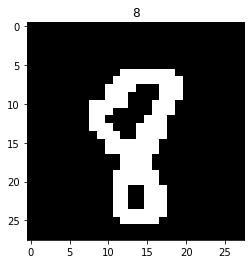

In [696]:
show_image(x[0], y[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


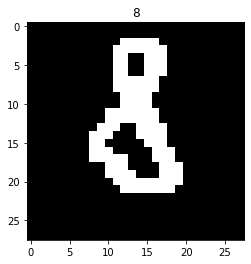

In [704]:
img = x[0]
img_flipped = transforms.RandomVerticalFlip(p=1)(img)
show_image(img_flipped, y[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


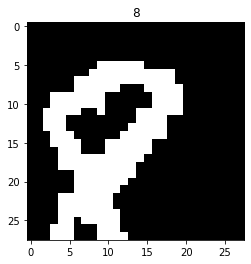

In [816]:
img = x[0]
img_affine = transforms.RandomAffine(degrees=30,            # degrees of rotation
                                     translate=(0.2,0.2),  # (x,y) translation (with center invariant)
                                     scale=(0.5,1.5)            # scale change
                                     )(img)
show_image(img_affine, y[0])

We need to be careful with these transformations because they can nontrivially obscure the meaning of the numbers. For example, if the bottom of this 8 were cropped out of the image, then it could validly be interpreted as a 0, a flipped and cropped 6, or a cropped 9. We can use vertical flips and rotations but should not pair them with horizontal flips (because then 6s and 9s could get mixed up).

In [820]:
# we can string transformations together using Compose()
data_transforms = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),    # range of degrees to select from
])

#### Create New Dataset with Transformed Data

In [837]:
tdat = datMNIST(path/'train.csv', img_format=True)
tdat_transformed = datMNIST(path/'train.csv', transforms=data_transforms, img_format=True)

# concatenate with original tdat dataset
aug_tdat = torch.utils.data.ConcatDataset((tdat, tdat_transformed))

In [838]:
len(tdat), len(aug_tdat)

(42000, 84000)

In [839]:
# create training and validation sets
tr_ds, val_ds = torch.utils.data.random_split(aug_tdat, [0.8, 0.2])

In [840]:
# create dataloaders
tr_dl = DataLoader(tr_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=True)

### Training CNN on Augmented Dataset

In [841]:
model = CNN(n_layers = 3,
            n_chan = 3,
            filter_size = 3,
            padding = 1,
            pooling = False)

optim = torch.optim.Adam(model.parameters())
train_cnn(model, tr_dl, epochs=10)

Epoch: 0 | Avg Training Loss: 0.8992               Val Loss: 0.3722 | Val Acc: 0.8788
Epoch: 1 | Avg Training Loss: 0.3274               Val Loss: 0.2792 | Val Acc: 0.9081
Epoch: 2 | Avg Training Loss: 0.2721               Val Loss: 0.2476 | Val Acc: 0.9162
Epoch: 3 | Avg Training Loss: 0.2490               Val Loss: 0.2629 | Val Acc: 0.9126
Epoch: 4 | Avg Training Loss: 0.2395               Val Loss: 0.2364 | Val Acc: 0.9184
Epoch: 5 | Avg Training Loss: 0.2293               Val Loss: 0.2206 | Val Acc: 0.9242
Epoch: 6 | Avg Training Loss: 0.2234               Val Loss: 0.223 | Val Acc: 0.9246
Epoch: 7 | Avg Training Loss: 0.2182               Val Loss: 0.2141 | Val Acc: 0.9273
Epoch: 8 | Avg Training Loss: 0.2120               Val Loss: 0.2067 | Val Acc: 0.9303
Epoch: 9 | Avg Training Loss: 0.2065               Val Loss: 0.2041 | Val Acc: 0.9319


Let's try with less aggressive transformations:

In [847]:
data_transforms = transforms.RandomAffine(degrees=10,            
                                     translate=(0.1,0.1),
                                     scale=(0.9,1.1)            
                                     )
tdat = datMNIST(path/'train.csv', img_format=True)
tdat_transformed = datMNIST(path/'train.csv', transforms=data_transforms, img_format=True)
aug_tdat = torch.utils.data.ConcatDataset((tdat, tdat_transformed))
tr_ds, val_ds = torch.utils.data.random_split(aug_tdat, [0.8, 0.2])
tr_dl = DataLoader(tr_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=True)

In [848]:
model = CNN(n_layers = 3,
            n_chan = 3,
            filter_size = 3,
            padding = 1,
            pooling = False)

optim = torch.optim.Adam(model.parameters())
train_cnn(model, tr_dl, epochs=10)

Epoch: 0 | Avg Training Loss: 0.9048               Val Loss: 0.3599 | Val Acc: 0.883
Epoch: 1 | Avg Training Loss: 0.2988               Val Loss: 0.2695 | Val Acc: 0.9155
Epoch: 2 | Avg Training Loss: 0.2502               Val Loss: 0.2341 | Val Acc: 0.924
Epoch: 3 | Avg Training Loss: 0.2231               Val Loss: 0.2283 | Val Acc: 0.9243
Epoch: 4 | Avg Training Loss: 0.2131               Val Loss: 0.2209 | Val Acc: 0.9274
Epoch: 5 | Avg Training Loss: 0.2029               Val Loss: 0.2001 | Val Acc: 0.9355
Epoch: 6 | Avg Training Loss: 0.2005               Val Loss: 0.1941 | Val Acc: 0.9352
Epoch: 7 | Avg Training Loss: 0.1963               Val Loss: 0.1885 | Val Acc: 0.9368
Epoch: 8 | Avg Training Loss: 0.1965               Val Loss: 0.1963 | Val Acc: 0.9361
Epoch: 9 | Avg Training Loss: 0.1858               Val Loss: 0.1801 | Val Acc: 0.9401


So, augmented data appears to make the model perform worse. Training this model for longer leads the validation accuracy to plateau around 0.94, which is quite bad. This may not be a bad thing though. Augmentation can make models more robust and thus improve performance on the hidden test dataset. Maybe combining augmentation with more complex architectures could improve performance. Also, I may be over-penalizing the achieved validation accuracy by including transformed images in the validation set. If we exclude transformations from the validation set, the model will likely perform better on it (not least because the ratio of the training dataset size to the validation dataset size will be expanded). So, I may actually expect better performance on the test dataset than on the validation dataset.

In [849]:
model = CNN(n_layers = 3,
            n_chan = 16,
            filter_size = 3,
            padding = 1,
            pooling = False)

optim = torch.optim.Adam(model.parameters())
train_cnn(model, tr_dl, epochs=10)

Epoch: 0 | Avg Training Loss: 0.3999               Val Loss: 0.1863 | Val Acc: 0.9388
Epoch: 1 | Avg Training Loss: 0.1469               Val Loss: 0.1274 | Val Acc: 0.9573
Epoch: 2 | Avg Training Loss: 0.1142               Val Loss: 0.1067 | Val Acc: 0.9631
Epoch: 3 | Avg Training Loss: 0.0991               Val Loss: 0.0984 | Val Acc: 0.9631
Epoch: 4 | Avg Training Loss: 0.0898               Val Loss: 0.0887 | Val Acc: 0.9691
Epoch: 5 | Avg Training Loss: 0.0782               Val Loss: 0.0782 | Val Acc: 0.9703
Epoch: 6 | Avg Training Loss: 0.0744               Val Loss: 0.0725 | Val Acc: 0.9717
Epoch: 7 | Avg Training Loss: 0.0696               Val Loss: 0.0768 | Val Acc: 0.9719
Epoch: 8 | Avg Training Loss: 0.0619               Val Loss: 0.0695 | Val Acc: 0.9744
Epoch: 9 | Avg Training Loss: 0.0619               Val Loss: 0.0645 | Val Acc: 0.9751


In [850]:
model = CNN(n_layers = 4,
            n_chan = 32,
            filter_size = 3,
            padding = 1,
            pooling = False)

optim = torch.optim.Adam(model.parameters())
train_cnn(model, tr_dl, epochs=10)

Epoch: 0 | Avg Training Loss: 0.3447               Val Loss: 0.1332 | Val Acc: 0.9578
Epoch: 1 | Avg Training Loss: 0.1185               Val Loss: 0.0974 | Val Acc: 0.9645
Epoch: 2 | Avg Training Loss: 0.0873               Val Loss: 0.0799 | Val Acc: 0.9702
Epoch: 3 | Avg Training Loss: 0.0719               Val Loss: 0.0662 | Val Acc: 0.9744
Epoch: 4 | Avg Training Loss: 0.0602               Val Loss: 0.0589 | Val Acc: 0.9769
Epoch: 5 | Avg Training Loss: 0.0516               Val Loss: 0.0559 | Val Acc: 0.9779
Epoch: 6 | Avg Training Loss: 0.0477               Val Loss: 0.0585 | Val Acc: 0.976
Epoch: 7 | Avg Training Loss: 0.0438               Val Loss: 0.0436 | Val Acc: 0.9799
Epoch: 8 | Avg Training Loss: 0.0412               Val Loss: 0.0425 | Val Acc: 0.9802
Epoch: 9 | Avg Training Loss: 0.0394               Val Loss: 0.0371 | Val Acc: 0.9829
